In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
from pathlib import Path
from lmfit.models import LinearModel
from lmfit import Parameters, minimize, report_fit
import statsmodels.formula.api as smf
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [15]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] 
fit_params_4U = fit_params_df[fit_params_df['disp_name'].str.contains('4U')]

# filter R2 > 0.5
nmr_deg_fit_params_df = fit_params_df[
    (fit_params_df['disp_name'].str.contains('NMR')) &
    (fit_params_df['diag_r2'] > 0.5)
    ]


In [76]:
def violinplot_lnkobs_dist(fits, temps, sites, disp_name, base, add_varplot = False):
    select_fits = fits.copy()

    # filt name contains "4U_wt" or "4U_a8c"
    select_fits = select_fits[select_fits['disp_name'].str.contains(disp_name)]
    # filter temps 25, 30, 37, 45, 52, 60, 75
    select_fits = select_fits[select_fits['temperature'].isin(temps)]
    select_fits_A = select_fits[select_fits['site'].isin(sites)]

    # filter out rg_id 20
    select_fits_A = select_fits_A[select_fits_A['rg_id'] != 20]

    # convert temp to int
    select_fits_A['temperature'] = select_fits_A['temperature'].astype(int)

    # get average at each 'inv_temp' and 'site'
    avg_kobs_A = select_fits_A.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()



    if len(temps) < 5:
        draw_points = 'points'
    else:
        draw_points = None

    if add_varplot:
        fig, axs = plt.subplots(2, 1, figsize=(2, 2.25), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

        # axs[0]: variance plot

        # calculate variance at each temperature
        var_kobs_A = select_fits_A.groupby(['inv_temp', 'temperature'])['log_kobs'].std().reset_index()
        sns.barplot(x='temperature', y='log_kobs', data=var_kobs_A, color='lightgray', ax=axs[0])
        axs[0].set_xlabel('Temperature (°C)')
        axs[0].set_ylabel(r'$\sigma_{\ln(k_{obs})}$')

        # axs[1]: violin plot
        sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_A, inner = draw_points, color = 'gray', ax = axs[1])
        axs[1].set_xlabel('Temperature (°C)')
        axs[1].set_ylabel(r'$\ln(k_{obs})$')
        plt.tight_layout()
        # move legend outside of plot
        plt.savefig(f'{disp_name}_avg_kobs_violin_{base}s_withVar.pdf')
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2, 2))
        sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_A, inner = draw_points, color = 'gray', ax = ax)
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel(r'$\ln(k_{obs})$')
        plt.tight_layout()
        # move legend outside of plot
        plt.savefig(f'{disp_name}_avg_kobs_violin_{base}s.pdf')
        plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


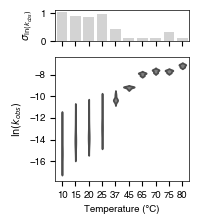

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


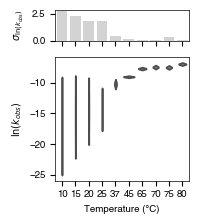

In [77]:
sites_dict_4U = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25]}
temps = [10, 15, 20, 25, 37, 45, 65, 70, 75, 80]
violinplot_lnkobs_dist(fit_params_df, temps, sites_dict_4U['A'], '4U_wt', 'A', add_varplot=True)
violinplot_lnkobs_dist(fit_params_df, temps, sites_dict_4U['C'], '4U_wt', 'C', add_varplot=True)